C:\Users\skpk\AppData\Local\Temp/ipykernel_21592/953838266.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_df_sorted['TIMESLICE'] = storage_df_sorted['TIMESLICE'].astype(int)


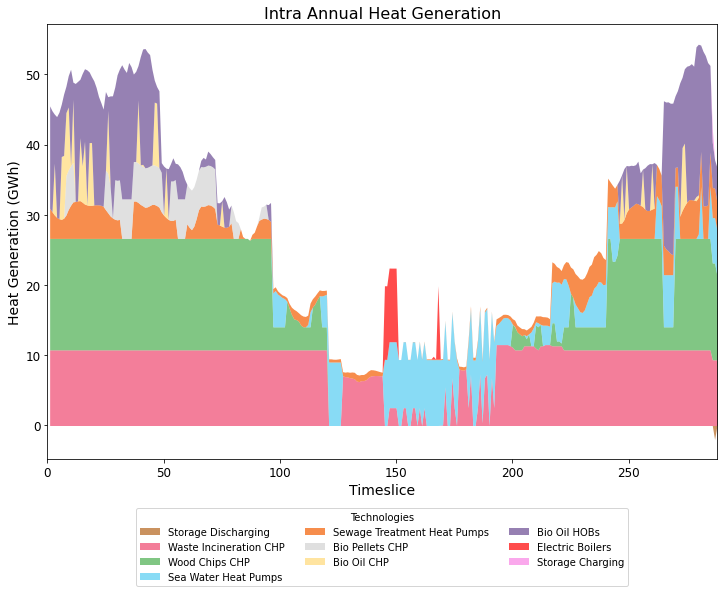

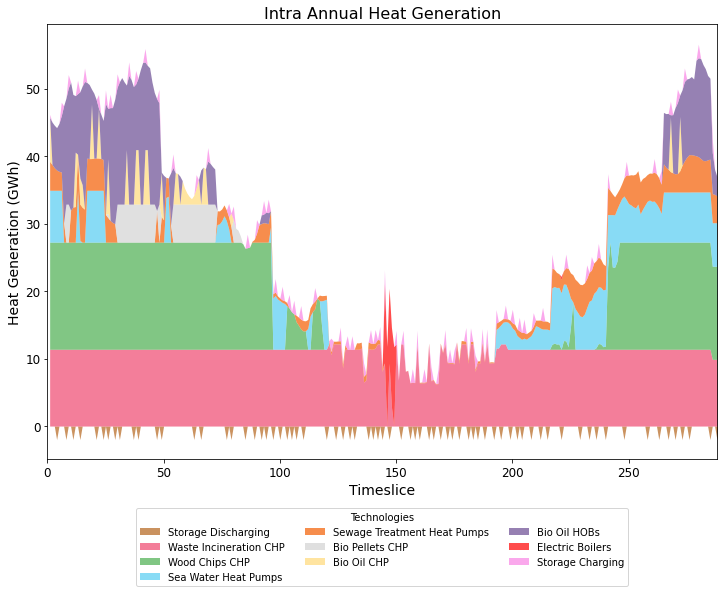

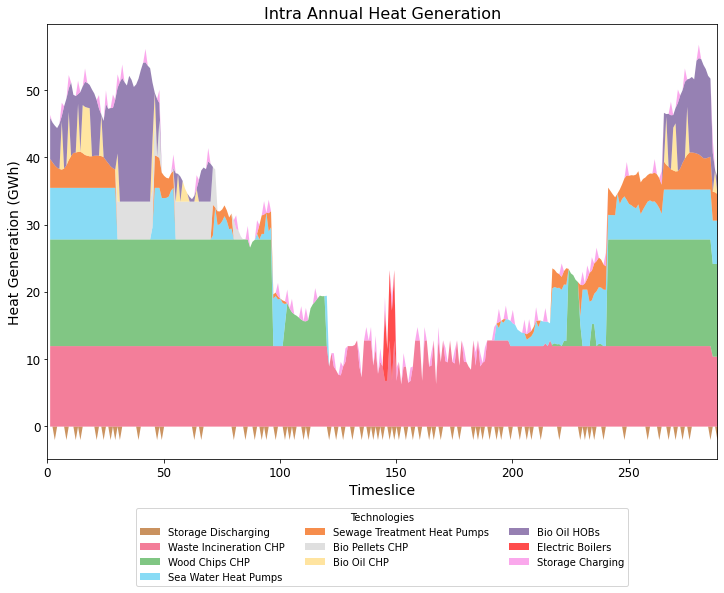

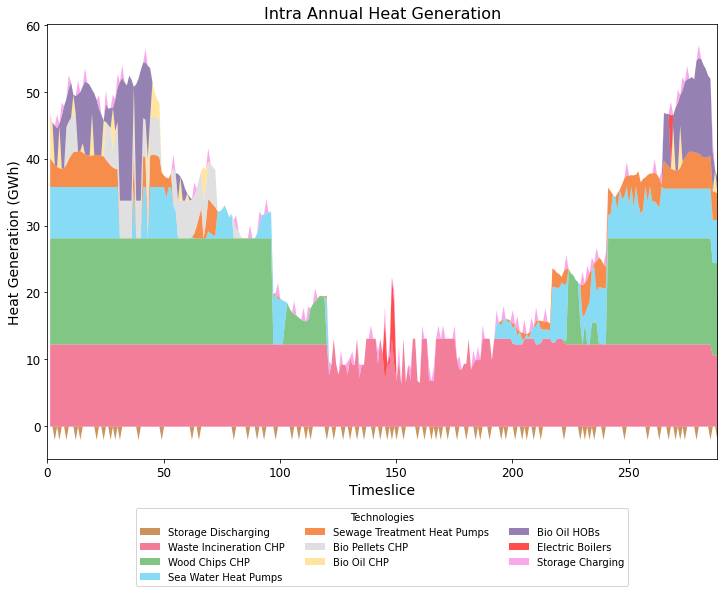

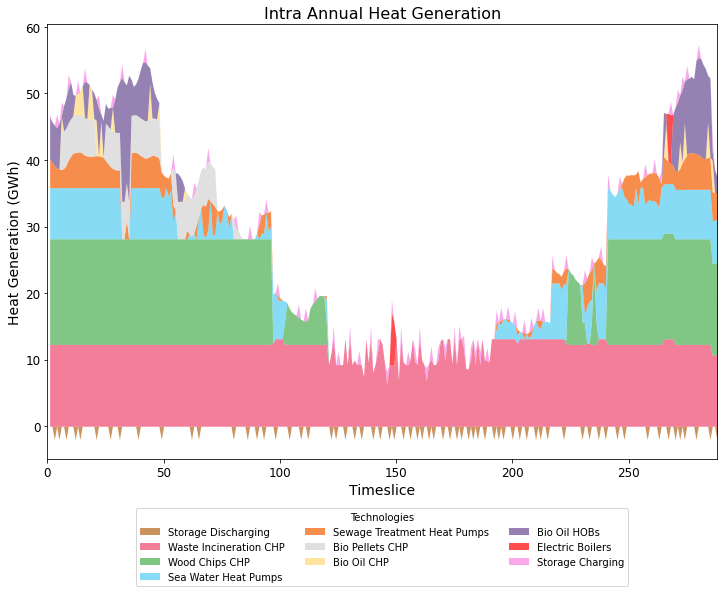

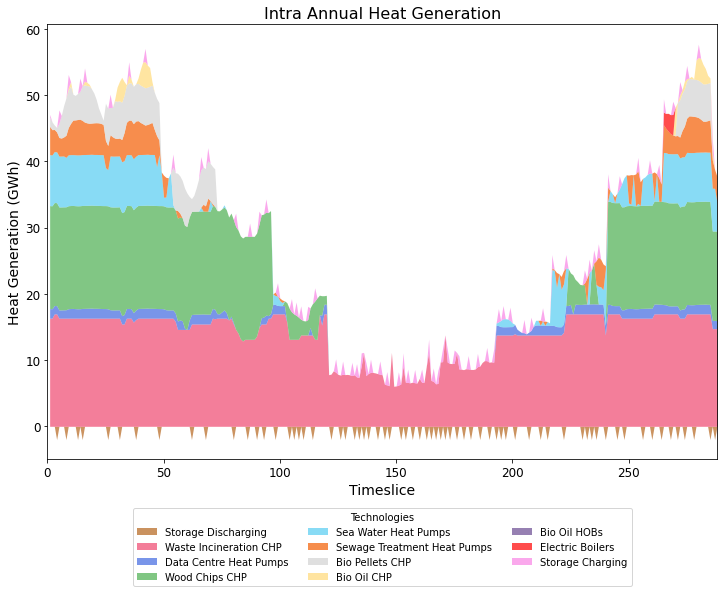

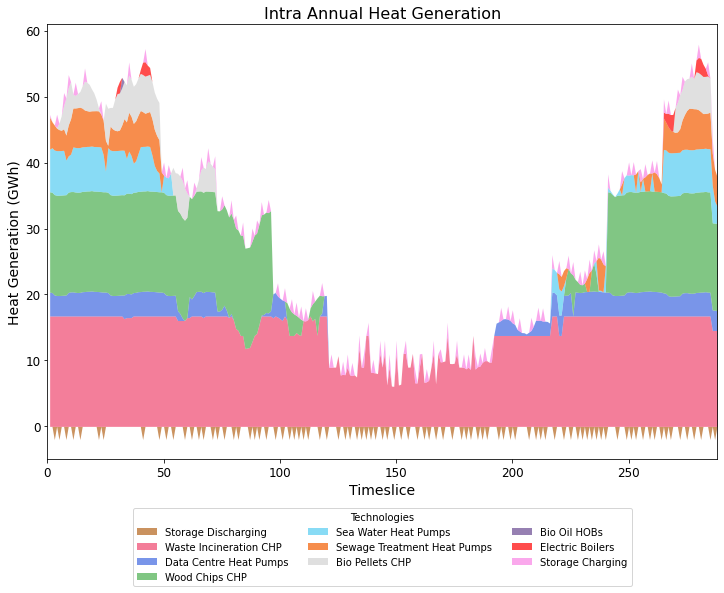

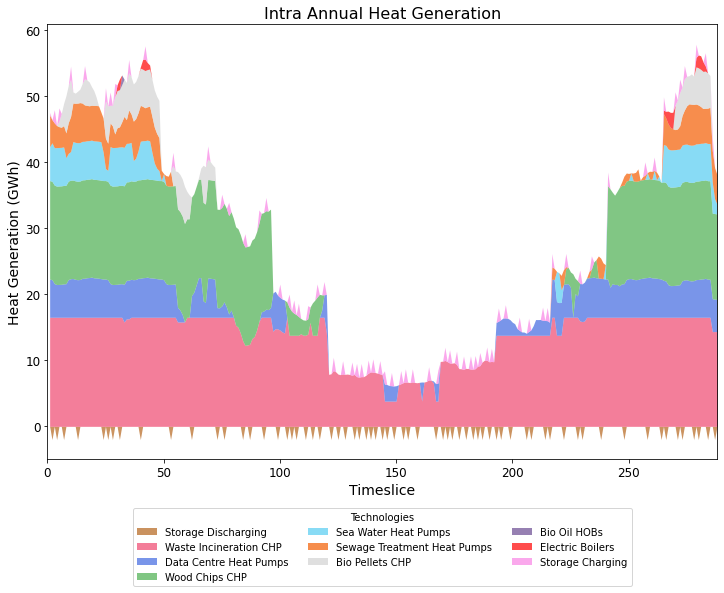

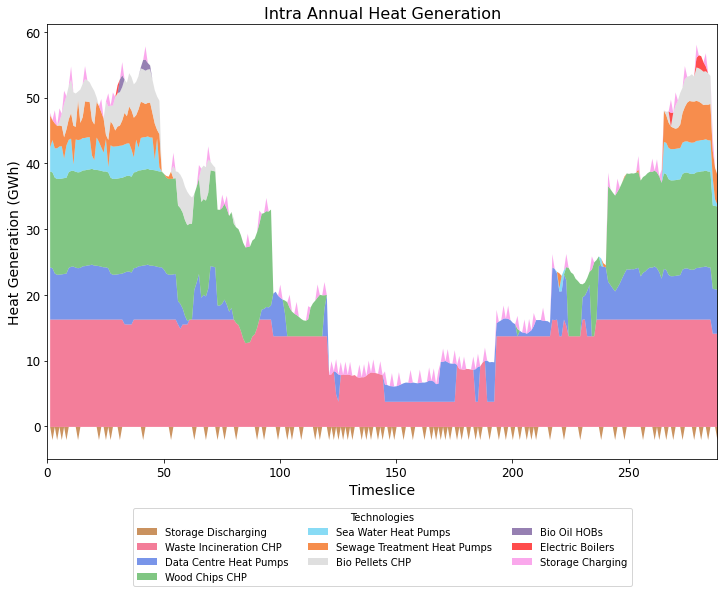

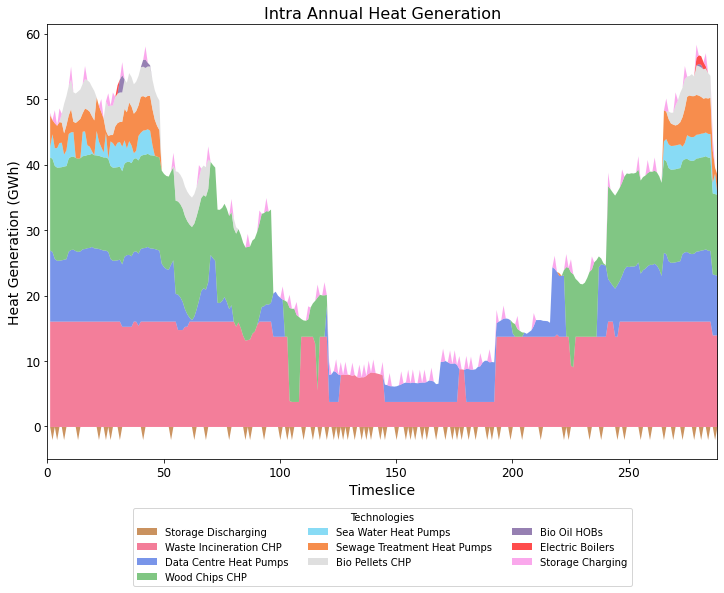

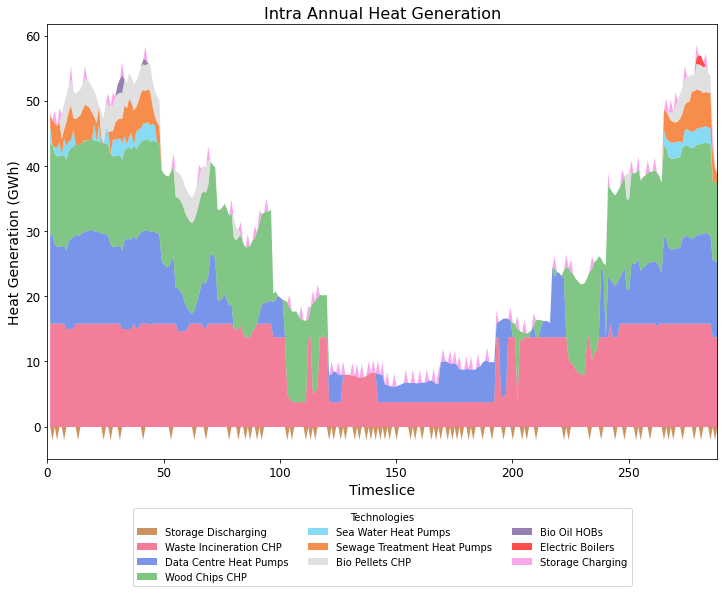

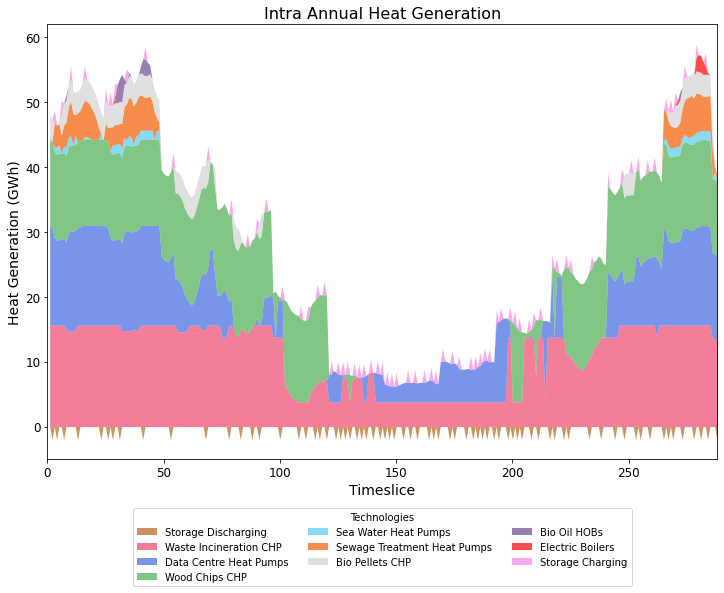

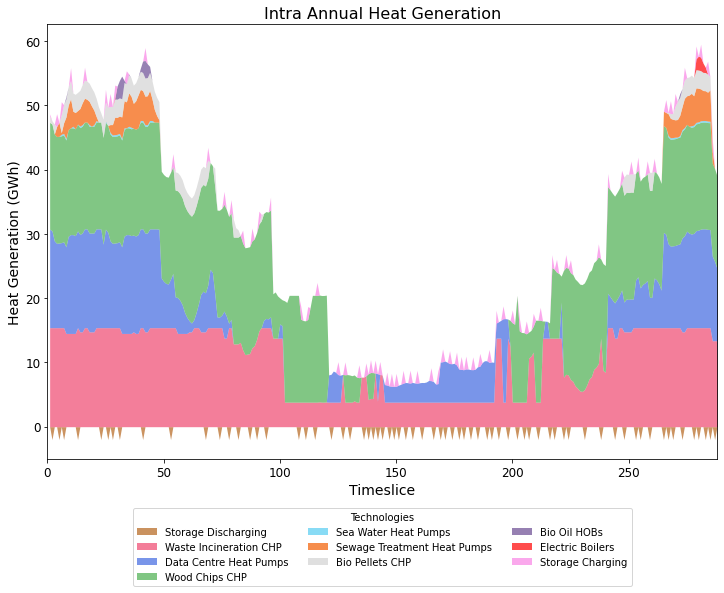

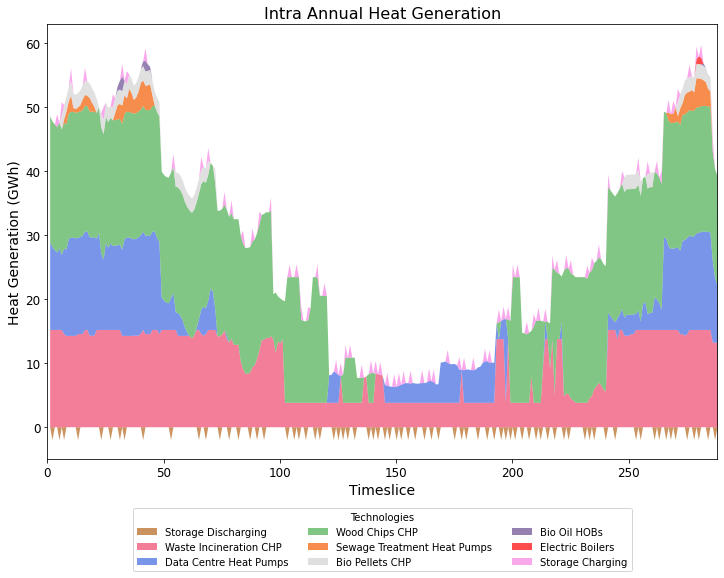

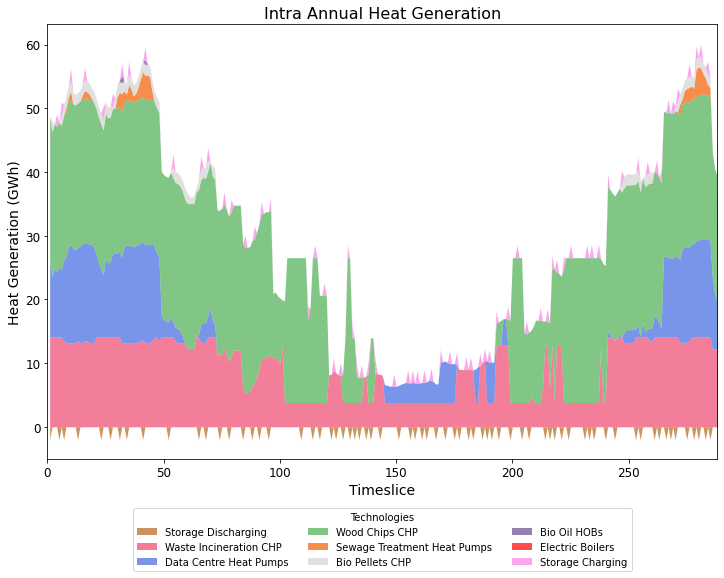

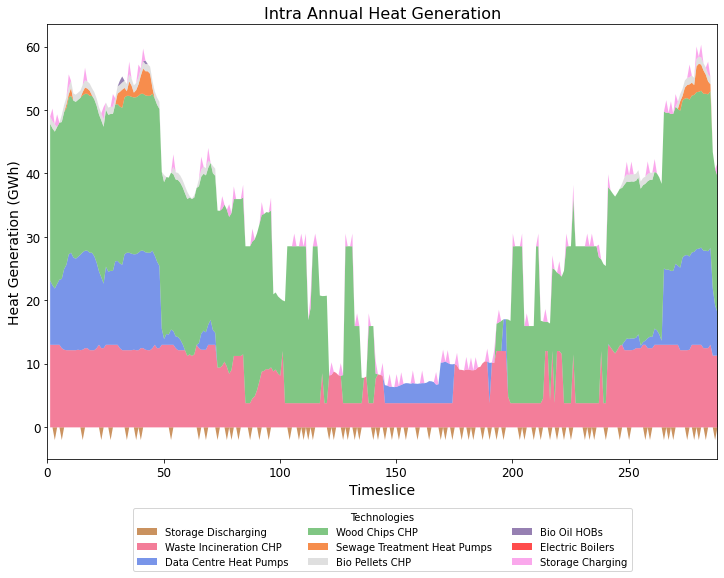

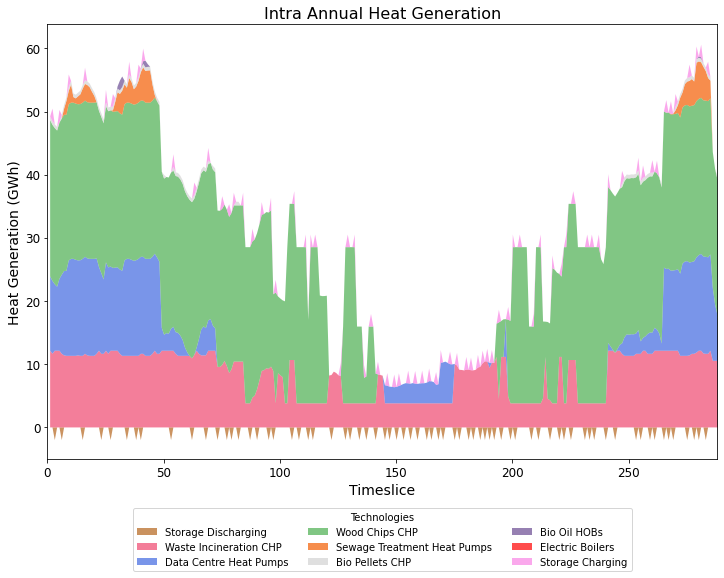

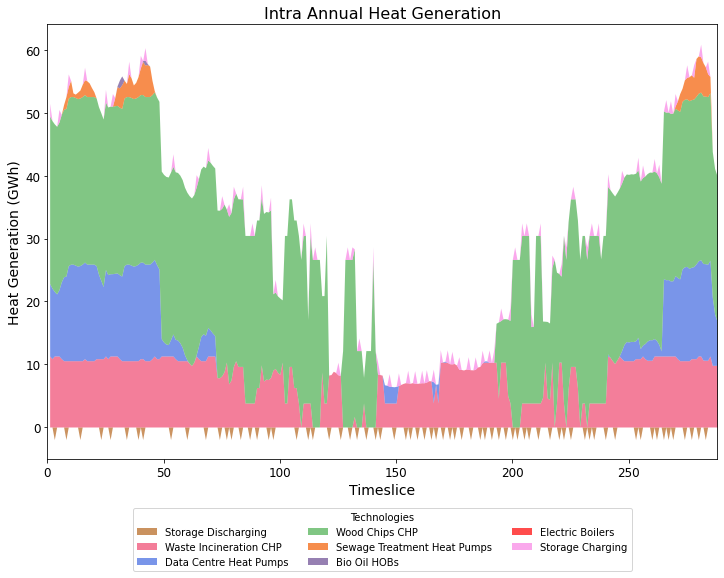

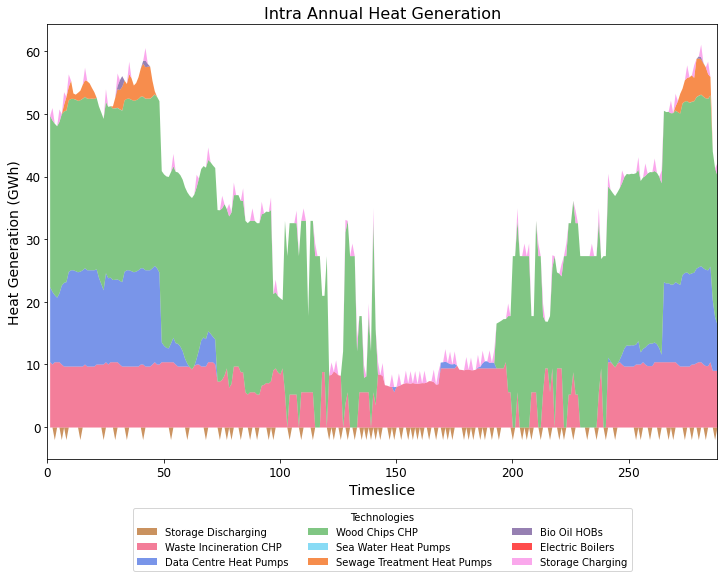

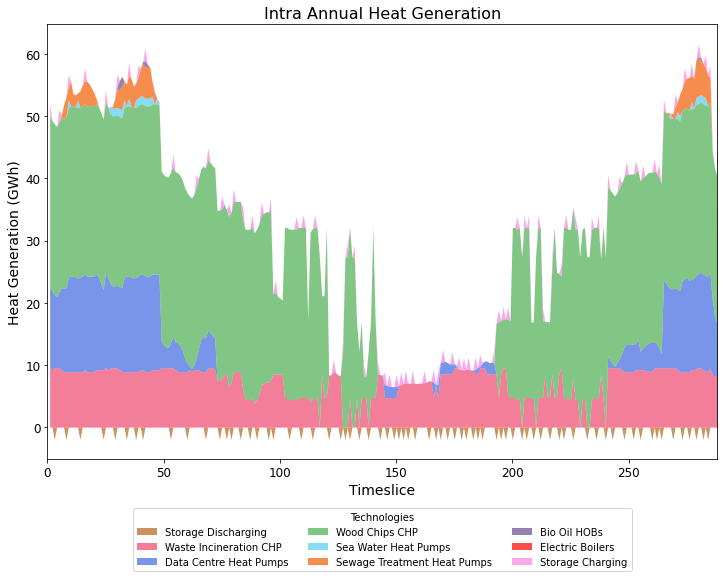

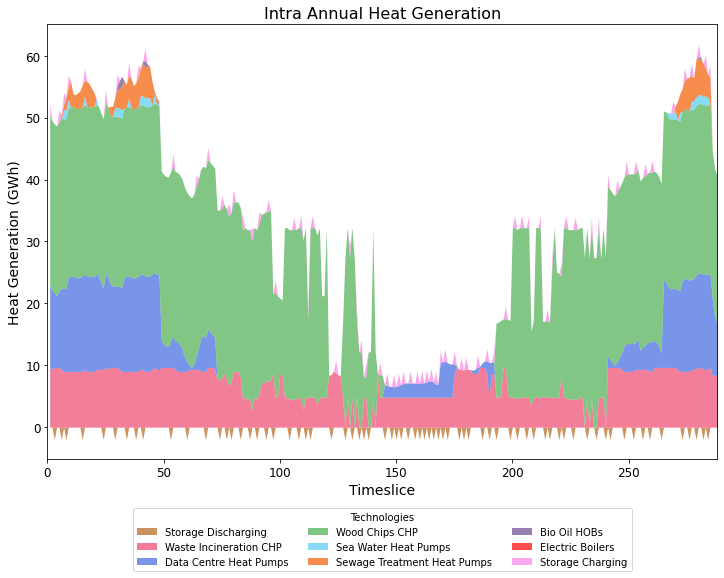

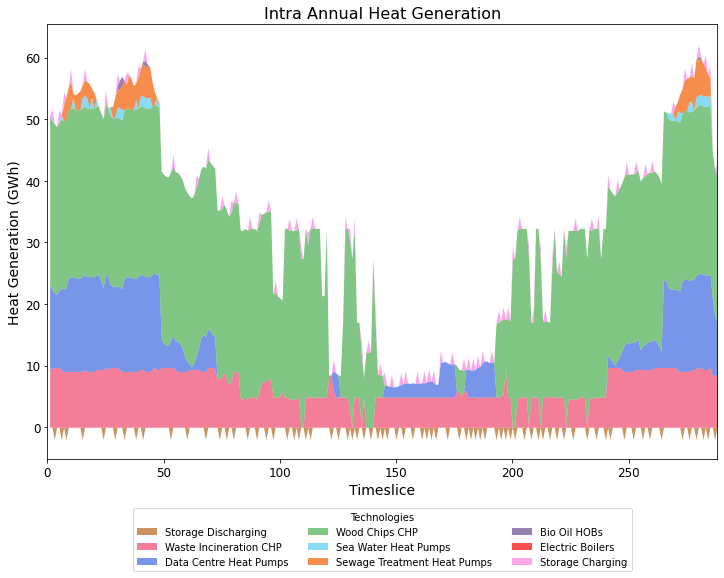

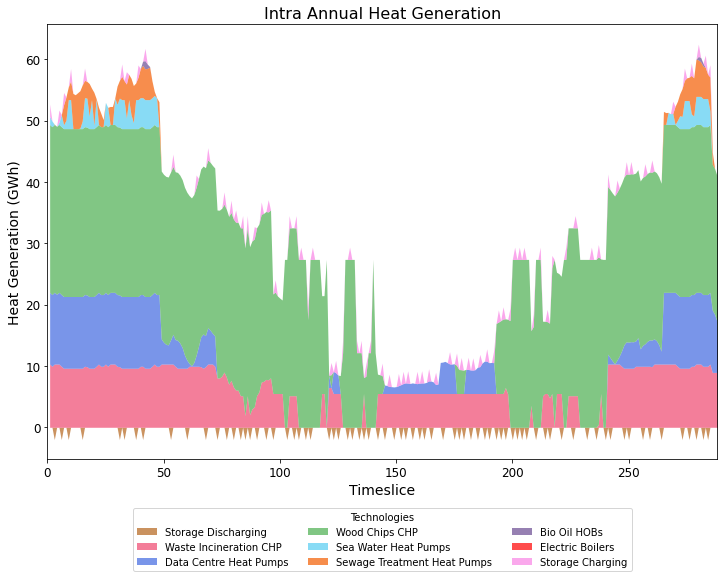

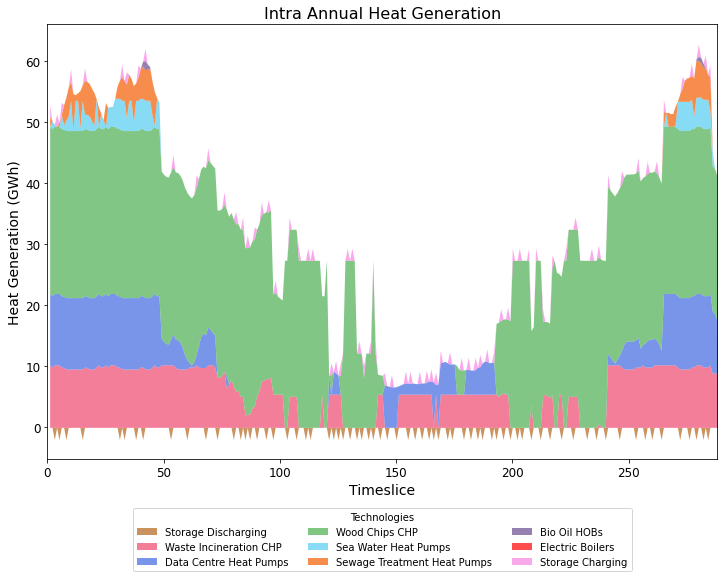

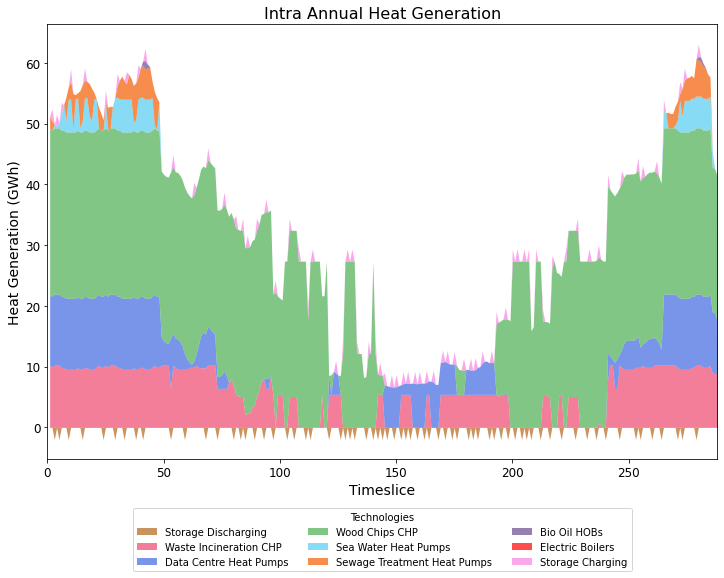

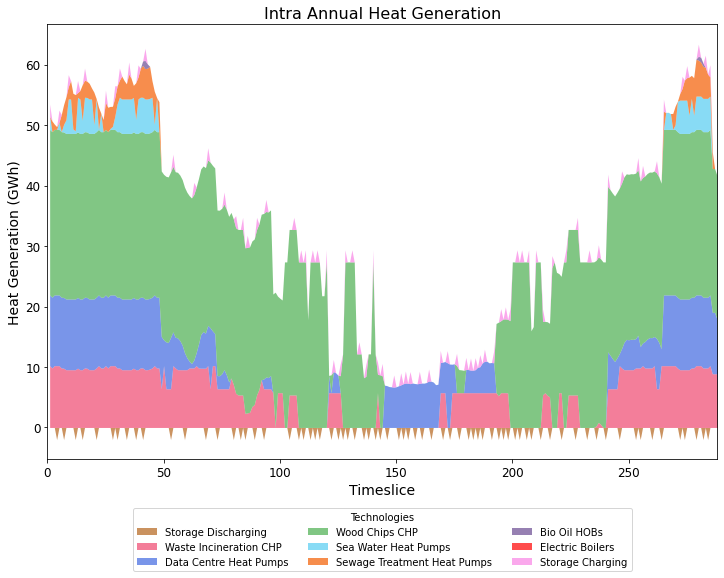

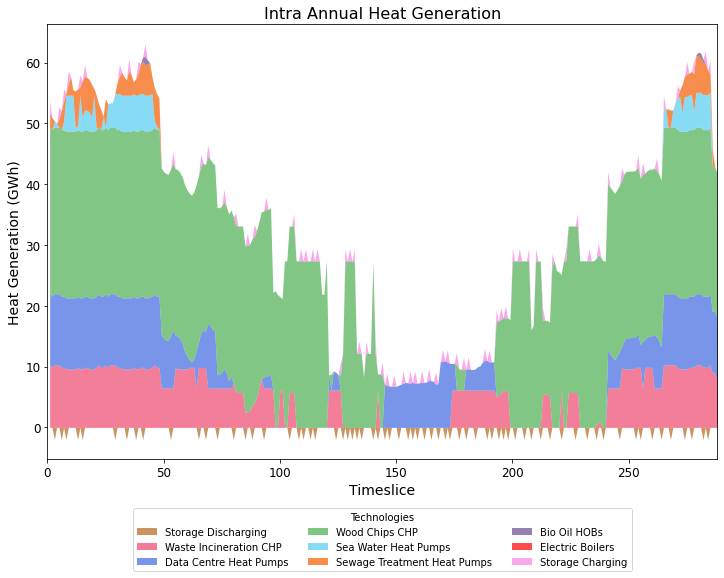

ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import os

# Specify the directory path
directory_path = r'C:\Users\skpk\OneDrive - KTH\OSeMOSYS_PULP_Short\SRC\Output_Data\LTLE\PBT_files'

storage_directory_path = r'C:\Users\skpk\OneDrive - KTH\OSeMOSYS_PULP_Short\SRC\Output_Data\LTLE\StorageLevelTimesliceStart.csv'
# List all files in the directory
file_names = [file for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))]

storage_df = pd.read_csv(storage_directory_path)
storage_df = storage_df.dropna(axis=1, how='all')
storage_df = storage_df.drop(columns=['NAME', 'SCENARIO','REGION'])
minyear = storage_df['YEAR'].min()
Storagepreviouslastvalue = 0

j = 0
for i in file_names:
    if '.xlsx' in str(i):
        df = pd.read_excel(i)
        PBT = df.loc[df['FUEL'].str.contains('CONVHEAT', case=False, na=False)]
        PBT = df.loc[df['FUEL'].str.contains('CONVHEAT', case=False, na=False)]
        mask = ~PBT['FUEL'].str.contains('DHN', case=False)
        PBT = PBT[mask]
        PBT = PBT.dropna(axis=1, how='all')
        PBT = PBT.drop(columns=['NAME', 'SCENARIO','REGION'])

            

        PBT_no_mode = PBT.groupby(['TECHNOLOGY', 'TIMESLICE'], as_index=False).agg({'VALUE': 'sum'})
        PBT_no_mode['VALUE'] = round(PBT_no_mode['VALUE']  * 0.2777777777777778, 2)
        PBT_no_mode1 = PBT_no_mode
        Names={
            'Electric Boilers': ['VVHVELHOB'],
            'Bio Oil CHP': ['KVV1'],
            'Bio Oil HOBs': ['DECFOHOB', 'CSBOHOB'],
            'Bio Pellets CHP': ['HslbyP1toP3'],
            'Sea Water Heat Pumps': ['VVNHP'],
            'Sewage Treatment Heat Pumps': ['HmrbySEWHP'],
            'Low Temperature Sources Heat Pumps': ['SUPACC'],
            'Waste Incineration CHP': ['BristaB2', 'HgldP3468', 'LSVTACHP'],
            'Wood Chips CHP': ['BristaB1', 'KVV8'],
            'Data Centre Heat Pumps': ['DCACC'],
        }


        # Reverse the Names dictionary for aggregation
        reverse_names = {tech: category for category, techs in Names.items() for tech in techs}

        # Map the TECHNOLOGY to their respective categories
        PBT_no_mode['CATEGORY'] = PBT_no_mode['TECHNOLOGY'].map(reverse_names)

        # Group by CATEGORY and TIMESLICE, summing the VALUE
        aggregated_df = PBT_no_mode.groupby(['CATEGORY', 'TIMESLICE'], as_index=False).agg({'VALUE': 'sum'})

        # Pivot the DataFrame for plotting
        pivot_df = aggregated_df.pivot(index='TIMESLICE', columns='CATEGORY', values='VALUE').fillna(0)

        ### STORAGE ###


        storage_df_sorted = storage_df.loc[storage_df['YEAR'] == int(re.sub('.xlsx', "", i))]
        storage_df_sorted['TIMESLICE'] = storage_df_sorted['TIMESLICE'].astype(int)
        storage_df_sorted = storage_df_sorted.sort_values(by=['TIMESLICE'], ascending=True, inplace=False, ignore_index=False)
        storage_df_sorted['VALUE'] = round(storage_df_sorted['VALUE']  * 0.2777777777777778, 2)
        Storage = storage_df_sorted['VALUE'].to_list()
        
        Storagecharge = []
        Storagedischarge = []

        for k in range(0,len(Storage)):
            if i==0:
                if Storage[k] - Storagepreviouslastvalue >= 0:
                    Storagecharge.append(Storage[k] - Storagepreviouslastvalue)
                    Storagedischarge.append(0)
                else:
                    Storagedischarge.append(Storage[k] - Storagepreviouslastvalue)
                    Storagecharge.append(0)
            else:
                if Storage[k] - Storage[k-1] >= 0:
                    Storagecharge.append(Storage[k] - Storage[k-1])
                    Storagedischarge.append(0)
                else:
                    Storagedischarge.append(Storage[k] - Storage[k-1])
                    Storagecharge.append(0)
        
        Storagepreviouslastvalue = Storage[-1]
        pivot_df['Storage Disharging'] = Storagecharge
        pivot_df['Storage Charging'] = Storagedischarge

        desired_order = ['Storage Discharging', 'Waste Incineration CHP', 'Data Centre Heat Pumps', 'Wood Chips CHP', 'Sea Water Heat Pumps', 'Sewage Treatment Heat Pumps',
                        'Bio Pellets CHP', 'Low Temperature Sources Heat Pumps', 'Bio Oil CHP', 'Bio Oil HOBs', 'Electric Boilers', 'Storage Charging']

        pivot_df = pivot_df.reindex(columns=desired_order)

        pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]
        # Plot area graph
        # Define your specific colors
        technology_colors1 = {
            'Electric Boilers': '#FF5722',          # Deep Orange
            'Data Centre Heat Pumps': '#1976D2',   # Bright Blue
            'Bio Oil CHP': '#654321',              # Dark Brown
            'Bio Oil HOBs': '#FBC02D',             # Bright Yellow
            'Bio Pellets CHP': '#8E24AA',          # Bright Purple
            'Sea Water Heat Pumps': '#0288D1',      # Bright Sea Blue
            'Sewage Treatment Heat Pumps': '#B0BEC5', # Light Grey
            'Low Temperature Sources Heat Pumps': '#FFD600',  # Bright Gold
            'Waste Incineration CHP': '#D32F2F',  # Bright Red
            'Wood Chips CHP': '#388E3C'           # Bright Green
        }

        technology_colors2 = {
            'Electric Boilers': '#440154',          # Deep Purple
            'Data Centre Heat Pumps': '#3B528B',    # Blue
            'Bio Oil CHP': '#21918C',               # Teal
            'Bio Oil HOBs': '#5EC962',              # Light Green
            'Bio Pellets CHP': '#FDE725',           # Yellow
            'Sea Water Heat Pumps': '#482878',      # Dark Blue-Purple
            'Sewage Treatment Heat Pumps': '#35B779', # Bright Green
            'Low Temperature Sources Heat Pumps': '#FDE725',  # Gold-Yellow
            'Waste Incineration CHP': '#9E0142',    # Deep Red
            'Wood Chips CHP': '#F46D43'             # Bright Orange
        }

        technology_colors3 = {
            'Electric Boilers': '#66C2A5',          # Soft Green
            'Data Centre Heat Pumps': '#FC8D62',    # Coral
            'Bio Oil CHP': '#8DA0CB',               # Soft Blue
            'Bio Oil HOBs': '#E78AC3',              # Light Pink
            'Bio Pellets CHP': '#A6D854',           # Lime Green
            'Sea Water Heat Pumps': '#FFD92F',      # Bright Yellow
            'Sewage Treatment Heat Pumps': '#E5C494', # Pale Yellow
            'Low Temperature Sources Heat Pumps': '#B3B3B3',  # Grey
            'Waste Incineration CHP': '#E41A1C',    # Red
            'Wood Chips CHP': '#4DAF4A'             # Bright Green
        }

        technology_colors4 = {
            'Electric Boilers': '#4E79A7',          # Blue
            'Data Centre Heat Pumps': '#F28E2B',    # Orange
            'Bio Oil CHP': '#E15759',               # Red
            'Bio Oil HOBs': '#76B7B2',              # Teal
            'Bio Pellets CHP': '#59A14F',           # Green
            'Sea Water Heat Pumps': '#EDC948',      # Yellow
            'Sewage Treatment Heat Pumps': '#B07AA1', # Purple
            'Low Temperature Sources Heat Pumps': '#FF9DA7',  # Light Pink
            'Waste Incineration CHP': '#9C755F',    # Brown
            'Wood Chips CHP': '#BAB0AC'             # Light Grey
        }

        technology_colors5 = {
                            'Electric Boilers': '#FF0000',          # Coral Red
                            'Data Centre Heat Pumps': '#4169E1',    # Turquoise
                            'Bio Oil CHP': '#FFDA79',               # Bright Yellow
                            'Bio Oil HOBs': '#6A4C93',              # Vivid Purple
                            'Bio Pellets CHP': '#D3D3D3',           # Peach Orange
                            'Sea Water Heat Pumps': '#56CCF2',      # Bright Sky Blue
                            'Sewage Treatment Heat Pumps': '#F45D01', # Bright Orange
                            'Low Temperature Sources Heat Pumps': '#EE82EE',  # Pale Green
                            'Waste Incineration CHP': '#EF476F',    # Pinkish Red
                            'Wood Chips CHP': '#4CAF50',             # Bright Mint Green
                            'Storage Charging' : '#f984e5',
                            'Storage Discharging' : '#B5651D'
        }

        # Create a list of colors based on the pivot DataFrame's columns
        colors = [technology_colors5[col] for col in pivot_df.columns]


        # Plot area graph with specific colors
        ax = pivot_df.plot(kind='area', alpha=0.7, figsize=(12, 8), color=colors, linewidth=0)

        # Add labels and title
        plt.title('Intra Annual Heat Generation', fontsize=16)
        plt.xlabel('Timeslice', fontsize=14)
        plt.ylabel('Heat Generation (GWh)', fontsize=14)

        # Make lines sharper
        for patch in ax.patches:
            # patch.set_edgecolor('grey')  # Remove edge color for smoother transitions
            patch.set_linewidth(0)  # Set linewidth to 0 for no edges

        # Overlay with semi-transparent white to create a gloss effect
        for patch in ax.patches:
            patch.set_facecolor(patch.get_facecolor())
            gloss = plt.Rectangle((patch.get_x(), patch.get_y() + patch.get_height() * 0.5), 
                                patch.get_width(), patch.get_height() * 0.5, 
                                color='white', alpha=0.5, zorder=10)
            ax.add_patch(gloss)


        # Create a filtered legend for only existing categories
        existing_techs = pivot_df.columns
        legend_labels = [tech for tech in technology_colors1.keys() if tech in existing_techs]
        legend_colors = [technology_colors1[tech] for tech in legend_labels]
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]


        plt.legend(handles, legend_labels, title='Technologies', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim(0, 288)

        # Move the legend to the bottom as a horizontal box
        plt.legend(title='Technologies', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
        plt.grid(False)
        plt.savefig(f"PBT{i}.png", bbox_inches='tight', dpi=800)
        # Show plot
        plt.show()

C:\Users\skpk\AppData\Local\Temp/ipykernel_36060/462611407.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_df_sorted['TIMESLICE'] = storage_df_sorted['TIMESLICE'].astype(int)


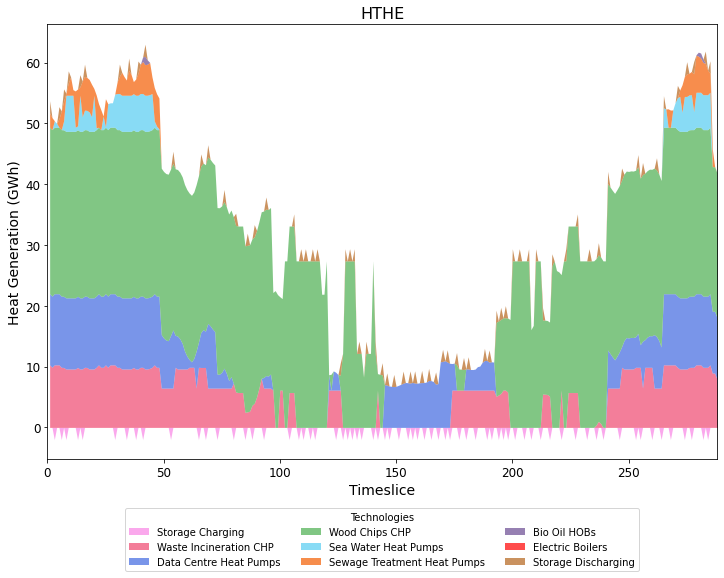

ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import os

# Specify the directory path
directory_path = r'C:\Users\skpk\OneDrive - KTH\OSeMOSYS_PULP_Short\SRC\Output_Data\LTLE\PBT_files'

storage_directory_path = r'C:\Users\skpk\OneDrive - KTH\OSeMOSYS_PULP_Short\SRC\Output_Data\LTLE\StorageLevelTimesliceStart.csv'
# List all files in the directory
file_names = [file for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))]

storage_df = pd.read_csv(storage_directory_path)
storage_df = storage_df.dropna(axis=1, how='all')
storage_df = storage_df.drop(columns=['NAME', 'SCENARIO','REGION'])
minyear = storage_df['YEAR'].min()
Storagepreviouslastvalue = 0

j = 0
for i in file_names:
    if '.xlsx' in str(i) and '2049' in i:
        df = pd.read_excel(i)
        PBT = df.loc[df['FUEL'].str.contains('CONVHEAT', case=False, na=False)]
        PBT = df.loc[df['FUEL'].str.contains('CONVHEAT', case=False, na=False)]
        mask = ~PBT['FUEL'].str.contains('DHN', case=False)
        PBT = PBT[mask]
        PBT = PBT.dropna(axis=1, how='all')
        PBT = PBT.drop(columns=['NAME', 'SCENARIO','REGION'])

            

        PBT_no_mode = PBT.groupby(['TECHNOLOGY', 'TIMESLICE'], as_index=False).agg({'VALUE': 'sum'})
        PBT_no_mode['VALUE'] = round(PBT_no_mode['VALUE']  * 0.2777777777777778, 2)
        PBT_no_mode1 = PBT_no_mode
        Names={
            'Electric Boilers': ['VVHVELHOB'],
            'Bio Oil CHP': ['KVV1'],
            'Bio Oil HOBs': ['DECFOHOB', 'CSBOHOB'],
            'Bio Pellets CHP': ['HslbyP1toP3'],
            'Sea Water Heat Pumps': ['VVNHP'],
            'Sewage Treatment Heat Pumps': ['HmrbySEWHP'],
            'Low Temperature Sources Heat Pumps': ['SUPACC'],
            'Waste Incineration CHP': ['BristaB2', 'HgldP3468', 'LSVTACHP'],
            'Wood Chips CHP': ['BristaB1', 'KVV8'],
            'Data Centre Heat Pumps': ['DCACC'],
        }


        # Reverse the Names dictionary for aggregation
        reverse_names = {tech: category for category, techs in Names.items() for tech in techs}

        # Map the TECHNOLOGY to their respective categories
        PBT_no_mode['CATEGORY'] = PBT_no_mode['TECHNOLOGY'].map(reverse_names)

        # Group by CATEGORY and TIMESLICE, summing the VALUE
        aggregated_df = PBT_no_mode.groupby(['CATEGORY', 'TIMESLICE'], as_index=False).agg({'VALUE': 'sum'})

        # Pivot the DataFrame for plotting
        pivot_df = aggregated_df.pivot(index='TIMESLICE', columns='CATEGORY', values='VALUE').fillna(0)

        ### STORAGE ###


        storage_df_sorted = storage_df.loc[storage_df['YEAR'] == int(re.sub('.xlsx', "", i))]
        storage_df_sorted['TIMESLICE'] = storage_df_sorted['TIMESLICE'].astype(int)
        storage_df_sorted = storage_df_sorted.sort_values(by=['TIMESLICE'], ascending=True, inplace=False, ignore_index=False)
        storage_df_sorted['VALUE'] = round(storage_df_sorted['VALUE']  * 0.2777777777777778, 2)
        Storage = storage_df_sorted['VALUE'].to_list()
        
        Storagecharge = []
        Storagedischarge = []

        for k in range(0,len(Storage)):
            if i==0:
                if Storage[k] - Storagepreviouslastvalue >= 0:
                    Storagecharge.append(Storage[k] - Storagepreviouslastvalue)
                    Storagedischarge.append(0)
                else:
                    Storagedischarge.append(Storage[k] - Storagepreviouslastvalue)
                    Storagecharge.append(0)
            else:
                if Storage[k] - Storage[k-1] >= 0:
                    Storagecharge.append(Storage[k] - Storage[k-1])
                    Storagedischarge.append(0)
                else:
                    Storagedischarge.append(Storage[k] - Storage[k-1])
                    Storagecharge.append(0)
        
        Storagepreviouslastvalue = Storage[-1]
        pivot_df['Storage Discharging'] = Storagecharge
        pivot_df['Storage Charging'] = Storagedischarge

        desired_order = ['Storage Charging', 'Waste Incineration CHP', 'Data Centre Heat Pumps', 'Wood Chips CHP', 'Sea Water Heat Pumps', 'Sewage Treatment Heat Pumps',
                        'Bio Pellets CHP', 'Low Temperature Sources Heat Pumps', 'Bio Oil CHP', 'Bio Oil HOBs', 'Electric Boilers','Storage Discharging']

        pivot_df = pivot_df.reindex(columns=desired_order)

        pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]
        # Plot area graph
        # Define your specific colors
        technology_colors1 = {
            'Electric Boilers': '#FF5722',          # Deep Orange
            'Data Centre Heat Pumps': '#1976D2',   # Bright Blue
            'Bio Oil CHP': '#654321',              # Dark Brown
            'Bio Oil HOBs': '#FBC02D',             # Bright Yellow
            'Bio Pellets CHP': '#8E24AA',          # Bright Purple
            'Sea Water Heat Pumps': '#0288D1',      # Bright Sea Blue
            'Sewage Treatment Heat Pumps': '#B0BEC5', # Light Grey
            'Low Temperature Sources Heat Pumps': '#FFD600',  # Bright Gold
            'Waste Incineration CHP': '#D32F2F',  # Bright Red
            'Wood Chips CHP': '#388E3C'           # Bright Green
        }

        technology_colors2 = {
            'Electric Boilers': '#440154',          # Deep Purple
            'Data Centre Heat Pumps': '#3B528B',    # Blue
            'Bio Oil CHP': '#21918C',               # Teal
            'Bio Oil HOBs': '#5EC962',              # Light Green
            'Bio Pellets CHP': '#FDE725',           # Yellow
            'Sea Water Heat Pumps': '#482878',      # Dark Blue-Purple
            'Sewage Treatment Heat Pumps': '#35B779', # Bright Green
            'Low Temperature Sources Heat Pumps': '#FDE725',  # Gold-Yellow
            'Waste Incineration CHP': '#9E0142',    # Deep Red
            'Wood Chips CHP': '#F46D43'             # Bright Orange
        }

        technology_colors3 = {
            'Electric Boilers': '#66C2A5',          # Soft Green
            'Data Centre Heat Pumps': '#FC8D62',    # Coral
            'Bio Oil CHP': '#8DA0CB',               # Soft Blue
            'Bio Oil HOBs': '#E78AC3',              # Light Pink
            'Bio Pellets CHP': '#A6D854',           # Lime Green
            'Sea Water Heat Pumps': '#FFD92F',      # Bright Yellow
            'Sewage Treatment Heat Pumps': '#E5C494', # Pale Yellow
            'Low Temperature Sources Heat Pumps': '#B3B3B3',  # Grey
            'Waste Incineration CHP': '#E41A1C',    # Red
            'Wood Chips CHP': '#4DAF4A'             # Bright Green
        }

        technology_colors4 = {
            'Electric Boilers': '#4E79A7',          # Blue
            'Data Centre Heat Pumps': '#F28E2B',    # Orange
            'Bio Oil CHP': '#E15759',               # Red
            'Bio Oil HOBs': '#76B7B2',              # Teal
            'Bio Pellets CHP': '#59A14F',           # Green
            'Sea Water Heat Pumps': '#EDC948',      # Yellow
            'Sewage Treatment Heat Pumps': '#B07AA1', # Purple
            'Low Temperature Sources Heat Pumps': '#FF9DA7',  # Light Pink
            'Waste Incineration CHP': '#9C755F',    # Brown
            'Wood Chips CHP': '#BAB0AC'             # Light Grey
        }

        technology_colors5 = {
                            'Electric Boilers': '#FF0000',          # Coral Red
                            'Data Centre Heat Pumps': '#4169E1',    # Turquoise
                            'Bio Oil CHP': '#FFDA79',               # Bright Yellow
                            'Bio Oil HOBs': '#6A4C93',              # Vivid Purple
                            'Bio Pellets CHP': '#D3D3D3',           # Peach Orange
                            'Sea Water Heat Pumps': '#56CCF2',      # Bright Sky Blue
                            'Sewage Treatment Heat Pumps': '#F45D01', # Bright Orange
                            'Low Temperature Sources Heat Pumps': '#EE82EE',  # Pale Green
                            'Waste Incineration CHP': '#EF476F',    # Pinkish Red
                            'Wood Chips CHP': '#4CAF50',             # Bright Mint Green
                            'Storage Charging' : '#f984e5',
                            'Storage Discharging' : '#B5651D'
        }

        # Create a list of colors based on the pivot DataFrame's columns
        colors = [technology_colors5[col] for col in pivot_df.columns]


        # Plot area graph with specific colors
        ax = pivot_df.plot(kind='area', alpha=0.7, figsize=(12, 8), color=colors, linewidth=0)

        # Add labels and title
        plt.title('HTHE', fontsize=16)
        plt.xlabel('Timeslice', fontsize=14)
        plt.ylabel('Heat Generation (GWh)', fontsize=14)

        # Make lines sharper
        for patch in ax.patches:
            # patch.set_edgecolor('grey')  # Remove edge color for smoother transitions
            patch.set_linewidth(0)  # Set linewidth to 0 for no edges

        # Overlay with semi-transparent white to create a gloss effect
        for patch in ax.patches:
            patch.set_facecolor(patch.get_facecolor())
            gloss = plt.Rectangle((patch.get_x(), patch.get_y() + patch.get_height() * 0.5), 
                                patch.get_width(), patch.get_height() * 0.5, 
                                color='white', alpha=0.5, zorder=10)
            ax.add_patch(gloss)


        # Create a filtered legend for only existing categories
        existing_techs = pivot_df.columns
        legend_labels = [tech for tech in technology_colors1.keys() if tech in existing_techs]
        legend_colors = [technology_colors1[tech] for tech in legend_labels]
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]


        plt.legend(handles, legend_labels, title='Technologies', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim(0, 288)

        # Move the legend to the bottom as a horizontal box
        plt.legend(title='Technologies', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
        plt.grid(False)
        plt.savefig(f"PBT{i}.png", bbox_inches='tight', dpi=800)
        # Show plot
        plt.show()

In [16]:
df = pd.read_excel('2023.xlsx')
PBT = df.loc[df['FUEL'].str.contains('CONVHEAT', case=False, na=False)]
PBT = df.loc[df['FUEL'].str.contains('CONVHEAT', case=False, na=False)]
mask = ~PBT['FUEL'].str.contains('DHN', case=False)
PBT = PBT[mask]
PBT = PBT.dropna(axis=1, how='all')
PBT = PBT.drop(columns=['NAME', 'SCENARIO','REGION', 'FUEL'])

PBT2 = PBT.loc[PBT['MODE_OF_OPERATION'] ==2]



In [ ]:
PBT2.loc[PBT2['VALUE 2'] > 0]

In [ ]:
Techlist = PBT2['TECHNOLOGY'].unique().tolist()
Techlist
PBT1 = PBT.loc[PBT['MODE_OF_OPERATION'] == 1]
PBT1 = PBT.loc[PBT['TECHNOLOGY'].isin(Techlist)]
PBT1 = PBT1.rename(columns={'VALUE': 'VALUE 1'}, inplace=False)
PBT2 = PBT2.rename(columns={'VALUE': 'VALUE 2'}, inplace=False)
PBT2


In [ ]:
PBT_new =  pd.merge(PBT1, PBT2, on=['TECHNOLOGY', 'YEAR', 'TIMESLICE'])
PBT_new

In [ ]:
onelist =PBT_new['VALUE 1'].to_list()
twolist =PBT_new['VALUE 2'].to_list()

averagelist = []

for i in range(0, len(onelist)):
    if (onelist[i] + twolist[i]) == 0:
        averagelist.append(0)
    else:
        average = twolist[i]/(onelist[i] + twolist[i])
        averagelist.append(average)

PBT_new['Average'] = averagelist
# 
# PBT_pivot
PBT_grouped = PBT_new.groupby(['TECHNOLOGY', 'TIMESLICE'], as_index=False).agg({'Average': 'sum'})
PBT_pivot = PBT_grouped.pivot(index='TIMESLICE', columns='TECHNOLOGY', values='Average').fillna(0)
PBT_pivot